| Column Name             | Example Value           | Description                            | Source/Method             |
|------------------------|-------------------------|----------------------------------------|---------------------------|
| `beach_id`             | 0001                    | Unique identifier for the beach        | Assigned                  |
| `timestamp`            | 2025-05-27 08:00:00     | Date and time of forecast              | Collected                 |
| `day`                  | Tuesday                 | Day of the week                        | Collected                 |
| `is_holiday`           | 0                       | Whether the day is a public holiday  | API (holidayapi.com) (i dont think im using this one anymore too much work, just gonna hard code it)  |
| `weather`              | Cloudy                  | Forecasted weather condition           | API (v1/archive or v1/forecast Open-Meteo, weather_code)    |
| `sea_temp`             | 17.8                    | Sea surface temperature in °C          | API (v1/marine Open-Meteo, sea_sruface_temperature)    |
| `wave_height`          | 1.4                     | Wave height in meters                  | API (v1/marine Open-Meteo, wave_height)    |
| `wind_speed`           | 9.5                     | Wind speed at 10m in km/h              | API (v1/archive or v1/forecastOpen-Meteo, wind_speed_10m)    |
| `crowdedness_percentage` | 62                    | Predicted crowdedness at that time     | Forecast model            |

## this jupyter notebook for creating realistic dummy data for past 3 months plus 1 week ahead from 05/27 

In [14]:
# import requests
# import json

# # HOLIDAYAPI.COM 
# # db8b28bb-631f-4c44-83c9-95c93a862d91
# url = 'https://holidayapi.com/v1/holidays'
# key = 'db8b28bb-631f-4c44-83c9-95c93a862d91'
# params = {
#     'key': key,
#     'country': 'US',
#     'year': 2024,
#     'public': True
# }

# response = requests.get(url, params=params)
# data = response.json()

# print(json.dumps(data, indent=2))

In [35]:
import pandas as pd
from datetime import datetime, timedelta

# --- Load Existing CSV ---
existing_file = "dummy_data.csv"
df_existing = pd.read_csv(existing_file)

# --- Generate New Hourly Entries for 3 Months ---
start_date = datetime(2025, 5, 27)
end_date = datetime(2025, 2, 27)
beach_ids = ['0001', '0002']
new_entries = []

current = start_date
while current >= end_date:
    for hour in range(24):
        timestamp = current.replace(hour=hour, minute=0, second=0)
        day_of_week = timestamp.strftime('%A')
        formatted_time = timestamp.strftime('%Y-%m-%dT%H:%M:%S')
        for beach_id in beach_ids:
            new_entries.append({
                "beach_id": beach_id,
                "timestamp": formatted_time,
                "day": day_of_week
            })
    current -= timedelta(days=1)

df_new = pd.DataFrame(new_entries)

# --- Align Columns with Existing Data ---
# Add missing columns to df_new and fill with NaN
for col in df_existing.columns:
    if col not in df_new.columns:
        df_new[col] = pd.NA

# Reorder columns to match existing file
df_new = df_new[df_existing.columns]

# --- Combine and Save ---
df_combined = pd.concat([df_existing, df_new], ignore_index=True)
df_combined.to_csv(existing_file, index=False)

print("✅ New rows added to existing CSV. Final shape:", df_combined.shape)


✅ New rows added to existing CSV. Final shape: (4320, 9)


In [36]:
# Path to your existing CSV
csv_path = "dummy_data.csv"

# Load it
df = pd.read_csv(csv_path)

# Define holidays to match against
us_holidays_2025 = {
    "2025-01-01", "2025-01-20", "2025-02-17", "2025-05-26",
    "2025-07-04", "2025-09-01", "2025-10-13", "2025-11-11",
    "2025-11-27", "2025-12-25"
}

# Add is_holiday column: 1 if date in holidays, else 0
df['is_holiday'] = pd.to_datetime(df['timestamp']).dt.strftime('%Y-%m-%d').isin(us_holidays_2025).astype(int)

# Overwrite the original CSV
df.to_csv(csv_path, index=False)

print(f"✅ Updated '{csv_path}' with 'is_holiday' column.")

✅ Updated 'dummy_data.csv' with 'is_holiday' column.


In [ ]:
# 1 = lower trestles
df['beach_id'] = df['beach_id'].astype(int)

# Filter only beach_id 1
df_1 = df[df['beach_id'] == 1].copy()

# Reformat timestamp to match Open-Meteo API format
df_1['timestamp'] = pd.to_datetime(df_1['timestamp']).dt.strftime('%Y-%m-%dT%H:00')

# Call Open-Meteo API for beach_id 1 (Lower Trestles)
url = "https://marine-api.open-meteo.com/v1/marine"
params = {
    "latitude": 33.381222, 
    "longitude": -117.59374,
    "past_days": 90,
    "hourly": ["wave_height", "sea_surface_temperature"],
    "forecast_days": 0,
    "timezone": "America/Los_Angeles"
}
response = requests.get(url, params=params)
data = response.json()

# Create DataFrame from API response
meteo_df = pd.DataFrame({
    "timestamp": data["hourly"]["time"],
    "wave_height": [round(h * 3.28084, 2) for h in data["hourly"]["wave_height"]],
    "sea_temp": [round(t * 9/5 + 32, 1) for t in data["hourly"]["sea_surface_temperature"]]
})

# Merge meteo data into df_1
df_1.drop(columns=["wave_height", "sea_temp"], errors='ignore', inplace=True)
df_1 = df_1.merge(meteo_df, on="timestamp", how="left")

# Revert timestamp to original format
df_1['timestamp'] = pd.to_datetime(df_1['timestamp']).dt.strftime('%Y-%m-%d %H:%M:%S')

# Inject updated rows back into main dataframe
df.loc[df['beach_id'] == 1, ['wave_height', 'sea_temp']] = df_1[['wave_height', 'sea_temp']].values

# Save (overwrite) the CSV
df.to_csv(csv_path, index=False)

print("✅ Weather data successfully updated for beach_id = 1 and CSV overwritten.")


✅ Weather data successfully updated for beach_id = 1 and CSV overwritten.


In [39]:
# 2 = scripps north
df_2 = df[df['beach_id'] == 2].copy()

# Reformat timestamp to match Open-Meteo API format
df_2['timestamp'] = pd.to_datetime(df_2['timestamp']).dt.strftime('%Y-%m-%dT%H:00')

url = "https://marine-api.open-meteo.com/v1/marine"
params = {
    "latitude": 32.86642846031068, 
    "longitude": -117.25470447519228,
    "past_days": 90,
    "hourly": ["wave_height", "sea_surface_temperature"],
    "forecast_days": 0,
    "timezone": "America/Los_Angeles"
}
response = requests.get(url, params=params)
data = response.json()

# Create DataFrame from API response
meteo_df = pd.DataFrame({
    "timestamp": data["hourly"]["time"],
    "wave_height": [round(h * 3.28084, 2) for h in data["hourly"]["wave_height"]],
    "sea_temp": [round(t * 9/5 + 32, 1) for t in data["hourly"]["sea_surface_temperature"]]
})

df_2.drop(columns=["wave_height", "sea_temp"], errors='ignore', inplace=True)
df_2 = df_2.merge(meteo_df, on="timestamp", how="left")

# Revert timestamp to original format
df_2['timestamp'] = pd.to_datetime(df_2['timestamp']).dt.strftime('%Y-%m-%d %H:%M:%S')

# Inject updated rows back into main dataframe
df.loc[df['beach_id'] == 2, ['wave_height', 'sea_temp']] = df_2[['wave_height', 'sea_temp']].values

# Save (overwrite) the CSV
df.to_csv(csv_path, index=False)

print("✅ Weather data successfully updated for beach_id = 2 and CSV overwritten.")


✅ Weather data successfully updated for beach_id = 2 and CSV overwritten.


In [ ]:
# Filter only beach_id 1
df_1 = df[df['beach_id'] == 1].copy()

# Reformat timestamp to match Open-Meteo API format
df_1['timestamp'] = pd.to_datetime(df_1['timestamp']).dt.strftime('%Y-%m-%dT%H:00')

# Open-Meteo API for wind speed and weather code
url = "https://historical-forecast-api.open-meteo.com/v1/forecast"
params = {
    "latitude": 33.381222, 
    "longitude": -117.59374,
    "past_days": 90,
    "hourly": ["wind_speed_10m", "weather_code"],
    "forecast_days": 0,
    "timezone": "America/Los_Angeles"
}
response = requests.get(url, params=params)
data = response.json()

# Convert wind speed from km/h → mph (1 km/h ≈ 0.621371 mph)
meteo_df = pd.DataFrame({
    "timestamp": data["hourly"]["time"],
    "wind_speed": [round(kmh * 0.621371, 2) for kmh in data["hourly"]["wind_speed_10m"]],
    "weather": data["hourly"]["weather_code"]
})

# Drop existing columns if needed
df_1.drop(columns=["wind_speed", "weather"], errors='ignore', inplace=True)

# Merge on timestamp
df_1 = df_1.merge(meteo_df, on="timestamp", how="left")

# Reformat timestamp back to original
df_1['timestamp'] = pd.to_datetime(df_1['timestamp']).dt.strftime('%Y-%m-%d %H:%M:%S')

# Replace only wind_speed and weather in the main DataFrame
df.loc[df['beach_id'] == 1, ['wind_speed', 'weather']] = df_1[['wind_speed', 'weather']].values

# Save final result
df.to_csv(csv_path, index=False)

print("✅ wind_speed (mph) and weather code inserted for beach_id = 1.")

✅ wind_speed (mph) and weather code inserted for beach_id = 1.


In [45]:
weather_code_lookup = {
    0: "Clear sky",
    1: "Mainly clear",
    2: "Partly cloudy",
    3: "Overcast",
    45: "Fog",
    48: "Depositing rime fog",
    51: "Light drizzle",
    53: "Moderate drizzle",
    55: "Dense drizzle",
    56: "Light freezing drizzle",
    57: "Dense freezing drizzle",
    61: "Slight rain",
    63: "Moderate rain",
    65: "Heavy rain",
    66: "Light freezing rain",
    67: "Heavy freezing rain",
    71: "Slight snow fall",
    73: "Moderate snow fall",
    75: "Heavy snow fall",
    77: "Snow grains",
    80: "Slight rain showers",
    81: "Moderate rain showers",
    82: "Violent rain showers",
    85: "Slight snow showers",
    86: "Heavy snow showers",
    95: "Thunderstorm",
    96: "Thunderstorm with slight hail",
    99: "Thunderstorm with heavy hail"
}


In [46]:
# Filter only beach_id 2
df_2 = df[df['beach_id'] == 2].copy()

# Reformat timestamp to match Open-Meteo API format
df_2['timestamp'] = pd.to_datetime(df_2['timestamp']).dt.strftime('%Y-%m-%dT%H:00')

# Open-Meteo API for wind speed and weather code (Beach 2)
url = "https://historical-forecast-api.open-meteo.com/v1/forecast"
params = {
    "latitude": 32.86642846031068,
    "longitude": -117.25470447519228,
    "past_days": 90,
    "hourly": ["wind_speed_10m", "weather_code"],
    "forecast_days": 0,
    "timezone": "America/Los_Angeles"
}
response = requests.get(url, params=params)
data = response.json()

# Convert wind speed from km/h → mph
meteo_df = pd.DataFrame({
    "timestamp": data["hourly"]["time"],
    "wind_speed": [round(kmh * 0.621371, 2) for kmh in data["hourly"]["wind_speed_10m"]],
    "weather": data["hourly"]["weather_code"]
})

# Drop old columns from df_2
df_2.drop(columns=["wind_speed", "weather"], errors='ignore', inplace=True)

# Merge on timestamp
df_2 = df_2.merge(meteo_df, on="timestamp", how="left")

# Convert timestamp back to original format
df_2['timestamp'] = pd.to_datetime(df_2['timestamp']).dt.strftime('%Y-%m-%d %H:%M:%S')

# Inject updated values into full DataFrame
df.loc[df['beach_id'] == 2, ['wind_speed', 'weather']] = df_2[['wind_speed', 'weather']].values

# Save final result
df.to_csv(csv_path, index=False)

print("✅ wind_speed (mph) and weather code inserted for beach_id = 2.")


✅ wind_speed (mph) and weather code inserted for beach_id = 2.


In [51]:
# Convert timestamp from ISO format to datetime object
df['timestamp'] = pd.to_datetime(df['timestamp'], format="%Y-%m-%dT%H:%M:%S")

# Extract hour and apply 0 crowdedness for hours between 9 PM (21) and 6 AM (6)
df['hour'] = df['timestamp'].dt.hour
df.loc[(df['hour'] >= 21) | (df['hour'] <= 6), 'crowdedness_percentage'] = 0

# Drop helper column
df.drop(columns=['hour'], inplace=True)

# Save the result
df.to_csv(csv_path, index=False)

print("✅ Nighttime hours (9 PM – 6 AM) set to 0 crowdedness.") 

✅ Nighttime hours (9 PM – 6 AM) set to 0 crowdedness.


C:\Users\chris\AppData\Local\Temp\ipykernel_31616\3181721029.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['wind_speed'] = pd.to_numeric(df['wind_speed'], errors='coerce')
C:\Users\chris\AppData\Local\Temp\ipykernel_31616\3181721029.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['wave_height'] = pd.to_numeric(df['wave_height'], errors='coerce')


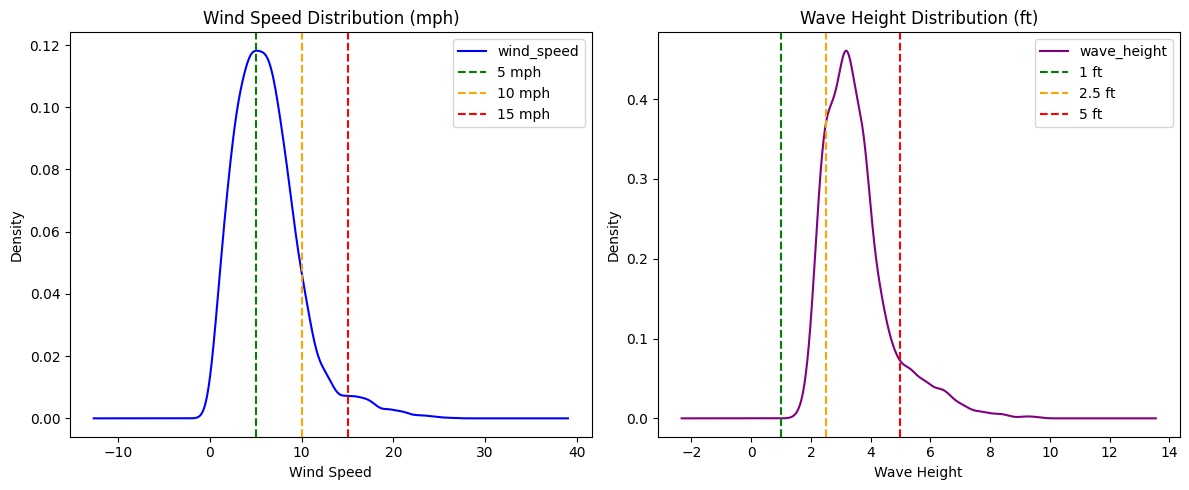

In [52]:
import pandas as pd
import matplotlib.pyplot as plt

# Drop missing values to avoid plotting issues
df = df.dropna(subset=['wind_speed', 'wave_height'])

# Convert to numeric just in case (if not already)
df['wind_speed'] = pd.to_numeric(df['wind_speed'], errors='coerce')
df['wave_height'] = pd.to_numeric(df['wave_height'], errors='coerce')

# Create density plots
plt.figure(figsize=(12, 5))

# --- Wind Speed Density Plot ---
plt.subplot(1, 2, 1)
df['wind_speed'].plot(kind='density', color='blue')
plt.axvline(5, color='green', linestyle='--', label='5 mph')
plt.axvline(10, color='orange', linestyle='--', label='10 mph')
plt.axvline(15, color='red', linestyle='--', label='15 mph')
plt.title('Wind Speed Distribution (mph)')
plt.xlabel('Wind Speed')
plt.legend()

# --- Wave Height Density Plot ---
plt.subplot(1, 2, 2)
df['wave_height'].plot(kind='density', color='purple')
plt.axvline(1, color='green', linestyle='--', label='1 ft')
plt.axvline(2.5, color='orange', linestyle='--', label='2.5 ft')
plt.axvline(5, color='red', linestyle='--', label='5 ft')
plt.title('Wave Height Distribution (ft)')
plt.xlabel('Wave Height')
plt.legend()

plt.tight_layout()
plt.show()


In [54]:
import numpy as np 
# Function to determine crowdedness
def assign_crowdedness(row):
    hour = row['timestamp'].hour
    wave = row['wave_height']
    wind = row['wind_speed']

    # Night hours
    if hour < 6 or hour >= 21:
        return 0

    if pd.isna(wave) or pd.isna(wind):
        return np.nan  # Skip if missing data

    # Ideal wave height
    if 2 <= wave <= 5:
        if wind <= 6:
            return np.random.randint(60, 101)
        elif wind <= 12:
            return np.random.randint(30, 61)
        else:
            return np.random.randint(10, 31)
    elif wave < 2:
        return np.random.randint(0, 31)
    elif wave > 5:
        if wind <= 6:
            return np.random.randint(30, 61)
        else:
            return np.random.randint(0, 21)
    return np.nan

# Apply the function
df['crowdedness_percentage'] = df['crowdedness_percentage'].combine_first(df.apply(assign_crowdedness, axis=1))

# Save over the original file
df.to_csv(csv_path, index=False)

print("✅ Crowdedness percentages assigned based on surf conditions.")

✅ Crowdedness percentages assigned based on surf conditions.
